---
# 0. 라이브러리
----

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!pip install torch pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[참고 사이트](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial16/Meta_Learning.html)

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from torchvision import transforms, datasets

from PIL import Image
from pprint import pprint
import easydict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # GPU 할당

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns 
import pandas as pd
import os
import random
import json
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy


import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

# Torchvision
import torchvision
from torchvision.datasets import CIFAR100, SVHN

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

---
# 2. Data
----

In [25]:
# CIFAR 데이터 다운로드
CIFAR_train_set = CIFAR100(root='./', train=True, download=True, transform=transforms.ToTensor())
CIFAR_test_set = CIFAR100(root='./', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


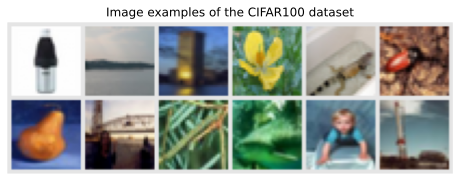

In [26]:
# 데이터 확인
NUM_IMAGES = 12
CIFAR_images = torch.stack([CIFAR_train_set[np.random.randint(len(CIFAR_train_set))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR100 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [27]:
CIFAR_train_set.data[0].shape

(32, 32, 3)

In [28]:
CIFAR_train_set.class_to_idx.items()

dict_items([('apple', 0), ('aquarium_fish', 1), ('baby', 2), ('bear', 3), ('beaver', 4), ('bed', 5), ('bee', 6), ('beetle', 7), ('bicycle', 8), ('bottle', 9), ('bowl', 10), ('boy', 11), ('bridge', 12), ('bus', 13), ('butterfly', 14), ('camel', 15), ('can', 16), ('castle', 17), ('caterpillar', 18), ('cattle', 19), ('chair', 20), ('chimpanzee', 21), ('clock', 22), ('cloud', 23), ('cockroach', 24), ('couch', 25), ('crab', 26), ('crocodile', 27), ('cup', 28), ('dinosaur', 29), ('dolphin', 30), ('elephant', 31), ('flatfish', 32), ('forest', 33), ('fox', 34), ('girl', 35), ('hamster', 36), ('house', 37), ('kangaroo', 38), ('keyboard', 39), ('lamp', 40), ('lawn_mower', 41), ('leopard', 42), ('lion', 43), ('lizard', 44), ('lobster', 45), ('man', 46), ('maple_tree', 47), ('motorcycle', 48), ('mountain', 49), ('mouse', 50), ('mushroom', 51), ('oak_tree', 52), ('orange', 53), ('orchid', 54), ('otter', 55), ('palm_tree', 56), ('pear', 57), ('pickup_truck', 58), ('pine_tree', 59), ('plain', 60), ('

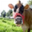

In [29]:
Image.fromarray(CIFAR_train_set.data[0])

---
# 3. Preprocessing
---

- 학습, 검증, 테스트 분할을 위해 기존 테스트와 학습을 위한 데이터셋을 병합 후 3가지로 재분해

In [30]:
CIFAR_all_images = np.concatenate([CIFAR_train_set.data, CIFAR_test_set.data], axis=0)
CIFAR_all_targets = torch.LongTensor(CIFAR_train_set.targets + CIFAR_test_set.targets)

In [31]:
class ImageDataset(Dataset):

  def __init__(self, img, targets, img_transform = None):
    super().__init__()
    self.img = img
    self.targets = targets
    self.img_transform = img_transform

  def __getitem__(self, idx):
    img, targets = self.img[idx], self.targets[idx]
    # numpy 배열을 Image객체로 변환
    img = Image.fromarray(img)

    if self.img_transform is not None:
      img = self.img_transform(img)

    return img, targets

  def __len__(self):
    return self.img.shape[0]

- 데이터셋 분할을 위한 코드

In [11]:
# 재현성을 위해 난수 발생의 시드를 0으로 설정합니다. 이렇게 하면 랜덤 시드가 같은 경우 매번 같은 결과를 얻을 수 있음
torch.manual_seed(0)

# torch.Tensor 형태로 반환되는 0 ~ 99 까지의 랜덤 순열
classes = torch.randperm(100) 

# 8:1:1 비율로 나눔
train_classes, val_classes, test_classes = classes[:80], classes[80:90], classes[90:]

In [12]:
# validation과 test의 class로 이름 확인
idx_to_class = {val: key for key, val in CIFAR_train_set.class_to_idx.items()}
print("Validation classes:", [idx_to_class[c.item()] for c in val_classes])
print("Test classes:", [idx_to_class[c.item()] for c in test_classes])

Validation classes: ['caterpillar', 'castle', 'skunk', 'ray', 'bus', 'motorcycle', 'keyboard', 'chimpanzee', 'possum', 'tiger']
Test classes: ['kangaroo', 'crocodile', 'butterfly', 'shark', 'forest', 'pickup_truck', 'telephone', 'lion', 'worm', 'mushroom']


- 목적은 Train_set에 있는 80개의 클래스로 부터 10개의 클래스 분류를 배우고,  
실제 Test_set의 클래스로 부터 10가지 예시를 추가적으로 배우고자 하는 것이다.

In [13]:
def dataset_from_labels(imgs, targets, class_set, **kwargs):

    '''[:, None]와 [None, :]는 각각 행렬에 차원을 추가해 주는 방법으로 
    기존 (3,) -> (3,1) / (3,) -> (1,3)으로 변경된다. 
    이는 서로 다른 크기를 갖는 배열에 대해 브로드캐스팅 연산을 사용하기 위해 차원을 확장하기 위함으로 사용된다.'''
    class_mask = (targets[:,None] == class_set[None,:]).any(dim=-1)
    return ImageDataset(img=imgs[class_mask],
                        targets=targets[class_mask],
                        **kwargs)

In [14]:
# 정규화에 사용될 평균 및 표준편차 값
DATA_MEANS = torch.Tensor([0.5183975 , 0.49192241, 0.44651328])
DATA_STD = torch.Tensor([0.26770132, 0.25828985, 0.27961241])

# transforms 모듈을 이요한 데이터 전치리 수행 코드
test_transform = transforms.Compose([transforms.ToTensor(), # tensor 변환
                                     transforms.Normalize(DATA_MEANS, DATA_STD) # 정규화
                                    ])

# train set에는 augmentation 추가
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # 좌우 반전
                                      transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)), # 이미지 자르기
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

In [15]:
train_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, train_classes, img_transform=train_transform)

val_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, val_classes, img_transform=test_transform)

test_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, test_classes, img_transform=test_transform)

---
# 4. Data Sampling
----

- 훈련 중에 few-shot training을 시뮬레이션 하는 것  

  각 훈련 단계에서, 소수의 클래스르 무작위로 선택하고 각 클래스에 대해 소수의 예제를 샘플링한다. 

  이를 Support_set 이라고 하는 few-shot training 배치 를 나타낸다. 

  또한 동일 클래스에서 두 번째 예제 세트를 샘플링하고 이 배치를 Query_set 이라고 한다. 

- 학습의 목표는 Support_set과 옳바른 레이블을 보는 것으로 부터 Query_set을 정확하게 분류하는 것이다.

----
#### ProtoNet
----
- ProtoNet은 few-shot learning 분야에서 대표적인 알고리즘 중 하나  
- 입력으로 주어진 이미지들의 클래스별 평균 feature를 계산하여 각 클래스에 대한 원형(hypersphere)을 생성
-  이렇게 생성된 원형으로부터 입력 이미지들의 feature와의 거리를 계산하여 이미지의 클래스를 분류

-  ProtoNet은 단순하면서도 효과적인 방법으로, 분류성능이 높은 것으로 알려져 있다.

---
#### MAML
----

- MAML은 Meta-learning의 대표적인 알고리즘 중 하나
-  MAML은 여러 종류의 학습 데이터들에 대해 적응성(adaptivity)을 갖는 모델을 학습하는 방법  

- 즉, 학습을 통해 초기 모델의 파라미터를 조정하여 각 데이터셋에 대해 높은 성능을 얻도록 하는 것 
- MAML은 학습 데이터셋에 노출되지 않은 새로운 데이터셋에 대해서도 빠르게 적응할 수 있는 모델을 생성하는 데에 효과적

---
#### Proto-MAML
----

- Proto-MAML은 ProtoNet과 MAML의 아이디어를 결합한 알고리즘 

- Proto-MAML은 각 클래스에 대해 prototype을 생성하고, 이를 이용해 MAML을 수행

- 이렇게 생성된 prototype은 새로운 데이터셋에 대해서도 일반화하기 용이
- 즉, Meta-learning과 few-shot learning을 통합한 알고리즘으로, 데이터셋이 적거나 클래스가 많은 상황에서 효과적

#### 차이점
---
#### 목적
----
- ProtoNet: few-shot classification
- MAML: meta-learning을 이용한 few-shot learning

- Proto-MAML: MAML의 성능을 개선하기 위해 Prototypical Network를 이용한 알고리즘

---
#### 모델 구조
---

- ProtoNet: 분류를 위한 간단한 프로토타입 모델

- MAML: 각 태스크에 대한 가중치를 최적화하는 데 사용되는 모델 파라미터를 가지는 meta-learner
- Proto-MAML: MAML과 마찬가지로 meta-learner를 사용하지만, 분류를 위해 ProtoNet으로 임베딩을 수행하는 모델

----
#### 학습 방법
----
- ProtoNet: 주어진 n-shot 샘플로부터 각 클래스에 대한 프로토타입을 생성하고, 이를 통해 새로운 샘플에 대한 분류를 수행합니다.

- MAML: 여러 태스크로부터 얻은 n-shot 샘플을 이용하여 meta-learner를 학습합니다. 이 학습된 meta-learner를 통해 새로운 태스크에서 적은 양의 데이터로 새로운 모델을 빠르게 학습합니다.

- Proto-MAML: MAML과 마찬가지로 meta-learner를 학습합니다. 이 meta-learner는 주어진 태스크에 대해 ProtoNet으로 임베딩을 수행하는 모델입니다. 
Proto-MAML은 ProtoNet과 MAML의 장점을 결합하여 n-shot 분류 성능을 높입니다.


요약하면, ProtoNet은 간단한 분류 모델을 사용하여 few-shot 분류를 수행하며, MAML은 meta-learning을 이용하여 few-shot learning을 수행합니다. Proto-MAML은 MAML의 meta-learning을 기반으로 ProtoNet의 프로토타입 모델을 사용하여 n-shot 분류를 개선하는 방법입니다.






In [16]:
class FewShotBatchSampler():

  def __init__(self, dataset_targets, N_way, K_shot,
               include_query = False,
               shuffle = True,
               shuffle_once = False):
    super().__init__()
  
    '''dataset_targets = 데이터 요소 레이블의 tensor
        N_way = 배치당 샘플링할 클래스 수
        K-shot = 배치에서 클래스 당 샘플링할 예제 수
        include_query = True인 경우 N_way * K-shot * 2 크기의 배치를 반환
          sup 및 qry 세트에 대해 동일한 클래스와 별개의 예제를 샘플링하는 구현을 단순화
        shuffle = True 이면 예제 및 클래스가 각 항목에서 새로 shffle
        shuffle_once = True 이면 예제와 클래스가 한 번씩 셔플 됨'''

    self.dataset_targets = dataset_targets
    self.N_way = N_way
    self.K_shot = K_shot
    self.shuffle = shuffle
    self.include_query = include_query
    if self.include_query :
      self.K_shot *= 2
    self.batch_size = self.N_way * self.K_shot

    '''batch_size를 N_way와 K_shot를 곱한 값으로 하는 이유는??
          
          N-way K-shot classification 문제를 해결하기 위해
          
          N-way K-shot문제란 N 개의 클래스 중 K개의 샘플만 사용하여 학습하는 분류 문제인데 
          N = 클래스의 수 / K = 각 클래스 마다 사용되는 샘플의 개수 
          N_way = 한 배치당 몇 개의 클래스르 사용할지 결정하는 변수
          K_shot = 각 클래스 당 몇 개의 샘플을 사용할지 결정하는 변수
          
          예를 들어  N_way = 5, K_shot = 1인 경우, 한 배치는 5개의 클래스를 가지며, 각 클래스당 1개의 샘플을 사용하여
          총 5 * 1 = 5개의 샘플이 한 배치를 이루게 된다.
          따라서 N_way와 K_shot를 곱하는 이뉴는 
          한 배치에서 사용할 이미지의 개수를 결정하기 위해서 이다.'''
    
    ############################# 클래스별 예제 구성 #############################
    # 고유한 클래스 라벨 추출
    self.classes = torch.unique(self.dataset_targets).tolist()
    
    # 클래스 총 개수 추출
    self.num_classes = len(self.classes)

    # 클래스 별 데이터셋의 인덱스
    self.indices_per_class = {}
    
    # 클래스 별 데이터셋의 K_shot 배치 개수
    self.batches_per_class = {} 

    # 각 클래스 별로 데이터셋의 인덱스를 추출
    for i in self.classes:
      self.indices_per_class[i] = torch.where(self.dataset_targets == i)[0]
      
      # 해당 클래스에서 만들 수 있는 k-shot 배치의 개수를 의미
      self.batches_per_class[i] = self.indices_per_class[i].shape[0] // self.K_shot
    ##########################################################################

    ############################# batch 당 N 개의 클래스를 선택하는 클래스 목록 구성 #############################
    # 각 클래스 마다 K-shot개의 이미지로 이루어진 배치를 몇 번 만들 수 있는지 계산해, 총 몇 번의 iteration이 필요한지 계산
    self.iterations = sum(self.batches_per_class.values()) // self.N_way

    # 각 iteration에서 선택할 N_way개의 클래스를 저장 / 각 클래스에서 생성 가능한 배치 수 만큼 클래스를 반복하여 리스트에 추가
    self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]

    # True일 경우 shuffle_data를 호출하여 클래스 리스틀 한 번 Shuffle
    if shuffle_once or self.shuffle:
      self.shuffle_data()
    
    # False일 경우 = 데이터셋을 test 할 경우를 의미
    # 클래스를 섞는 대신, 정해진 순서대로 iteration을 진행해야 하므로, 이를 위해 인덱스 리스트를 계산해 클래스 리스트를 순서대로 정렬(np.argsort(sort_list))
    else:
      sort_idxs = [i + p * self.num_classes for i, c in enumerate(self.classes) for p in range(self.batches_per_class[c])]
      self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()
    ######################################################################################################

  def shuffle_data(self):  # 각 배치에서 다른 클래스의 데이터를 섞어 overfitting을 방지하고 학습을 일반화 시킴
    
    # 클래스 당 예제별 shuffle 
    for c in self.classes:      
      # indices_per_class[c]에서 원소의 인덱스를 섞는다
      perm = torch.randperm(self.indices_per_class[c].shape[0])
      # 위에서 섞인 perm의 인덱스 순서에 따라 indices_per_class[c]의 원소들을 섞는다
      self.indices_per_class[c] = self.indices_per_class[c][perm]
    # 모든 클래스를 포함한 classes_list의 순서를 랜덤하게 섞는다
    random.shuffle(self.class_list)

  def __iter__(self):
    
    # Shuffle data
    if self.shuffle:
      self.shuffle_data()

    #################### few-shot 배치 샘플 ####################
    # 딕셔너리의 기본값을 0으로 설정
    start_index = defaultdict(int)
    
    for i in range(self.iterations):
      # N_way의 개수 만큼 클래스를 class_batch에 할당
      class_batch = self.class_list[i * self.N_way : (i + 1) * self.N_way]
      index_batch = []
      for c in class_batch:
        # 클래스 c 에서 K-shot 만큼 인덱스를 선택하여 index_batch에 추가
        index_batch.extend(self.indices_per_class[c][start_index[c] : start_index[c] + self.K_shot])
        # 다음 반복을 위해 K-shot 만큼 건너뛰어 선택하도록
        start_index[c] += self.K_shot
      
      # Query_set을 포함하도록 선택하였다면, sup_set과 qry_set을 번갈아 가면서 배치
      if self.include_query:
        index_batch = index_batch[::2] + index_batch[1::2]

      # btach를 생성하고 반환
      yield index_batch
    ###########################################################

  def __len__(self):
    return self.iterations

In [17]:
N_WAY = 5
K_SHOT = 4
train_data_loader = torch.utils.data.DataLoader(train_set,
                                    batch_sampler=FewShotBatchSampler(train_set.targets,
                                                                      include_query=True,
                                                                      N_way=N_WAY,
                                                                      K_shot=K_SHOT,
                                                                      shuffle=True),
                                    num_workers=1)
val_data_loader = torch.utils.data.DataLoader(val_set,
                                  batch_sampler=FewShotBatchSampler(val_set.targets,
                                                                    include_query=True,
                                                                    N_way=N_WAY,
                                                                    K_shot=K_SHOT,
                                                                    shuffle=False,
                                                                    shuffle_once=True),
                                  num_workers=1)

- 테스트

In [18]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

- sup_set과 qry_set 에는 동일한 5개의 클래스가 존재하지만 예제는 다르게 나타난다.

- 모델은 sup_set 및 해당 레이블에서 학습하여 qry_set의 예를 분류하는 task를 수행하게 된다. 

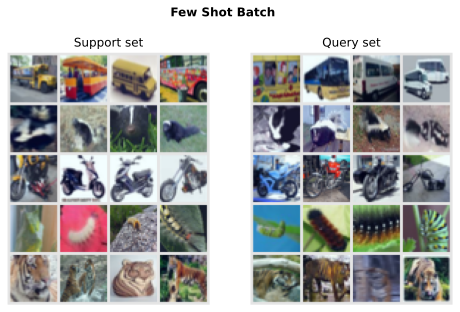

In [19]:
imgs, targets = next(iter(val_data_loader))  
support_imgs, query_imgs, _, _ = split_batch(imgs, targets)
support_grid = torchvision.utils.make_grid(support_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
support_grid = support_grid.permute(1, 2, 0)
query_grid = torchvision.utils.make_grid(query_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
query_grid = query_grid.permute(1, 2, 0)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(support_grid)
ax[0].set_title("Support set")
ax[0].axis('off')
ax[1].imshow(query_grid)
ax[1].set_title("Query set")
ax[1].axis('off')
plt.suptitle("Few Shot Batch", weight='bold')
plt.show()
plt.close()

---
# 5. Prototype Networks
---


### 기초 설명

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Frz2kp%2FbtqVZRVFp8N%2F6ZrlFuVbDoOluDtHln7NQ1%2Fimg.png'>



- 위 이미지의 동그란 색깔점(빨간, 파란, 초록) = Prototype 혹은 Prototype Representation 

- 회색의 네모 점은 각각의 색깔점과 거리를 계산해 가장 가까운 색깔점의 Class를 따르게 된다. (두 번째 그림)

- 각 Class에서 거리의 평균을 내 Prototype의 위치를 업데이트 진행 (세 번째 그림)


### 추가 설명

<img src='https://blog.kakaocdn.net/dn/QTf75/btqV2blwJop/GPGDedaSftJNpHDXvq2XGk/img.gif'>


- 3-Way 5-Shot의 구조 

1. C1의 초록색 부분만 계산한 다고 가정할 시  
  
  X1 ~ X5 (회색 네모)는 Support set의 tensor data 

2. 해당 tensor data를 모델에 넣으면 Z1 ~ Z5(초록색 원)이 만들어지게 됨

3. 각각의 Z값을 모두 평군한 값잉 C1 (검은색 원)이 되고 이것이 하나의 Class의 Prototype이 됨

- 위 과정을 반복해 C1, C2, C3처럼 3가지 Class의 Prototype을 구성하게 된다.

- 이후 Query set의 data 하나를 가져와 어떤 Class에 속하는지 예측하는 경우

- Query set의 tensor data는 Xq가 되고 Xq를 모델에 넣으면 Zq가 나오게 된다. (우측 하단 초록색 원)

- Zq를 가지고 C1, C2, C3와 각각 유클리드 거리를 계산한 후 - 를 붙이면 유사도가 된다.  
  (거리가 멀수록 즉, 값이 클수록 유사도는 낮은거니까 -를 붙여주면 값이 클수록 유사도가 커지게 된다.)

In [20]:
# DenseNet 불러오기
def get_convnet(output_size):
    convnet = torchvision.models.DenseNet(growth_rate=32,
                                          block_config=(6, 6, 6, 6),
                                          bn_size=2,
                                          num_init_features=64,
                                          num_classes=output_size  # Output dimensionality
                                         )
    return convnet

In [21]:
class ProtoNet(pl.LightningModule):

  def __init__(self, proto_dim, lr):
    super().__init__()
    self.proto_dim = proto_dim
    self.model = get_convnet(output_size=self.proto_dim)
    self.save_hyperparameters()
    self.lr = lr

  def configure_optimizers(self):
    optimizer = optim.AdamW(self.model.parameters(), lr = self.lr)
    scheduler = optim.lr_scheduler.MultiStepLR(
          optimizer, milestones = [140, 180], gamma = 0.1)
    
    return [optimizer], [scheduler]

  ################# few-shot classification에서 사용될 Prototype을 계산하는 함수 #################
  @staticmethod
  def calculate_prototypes(features, targets):
    # 정답 레이블에서 고유한 클래스 레이블을 찾아 리스트에 저장 및 정렬
    classes, _ = torch.unique(targets).sort()
    # 프로토타입을 저장할 빈 리스트
    prototypes = []
    for i in classes : # 클래스 라벨 i를 반복
      # 현재 클래스 i에 속하는 샘플들의 특징 벡터를 선택해 평균을 계산
      p = features[torch.where(targets == i)[0]].mean(dim = 0)
      prototypes.append(p)
    
    # prototypes 리스트를 tensor로 변환하여 반환 (dim = 0는 행으로 스택)
    prototypes = torch.stack(prototypes, dim = 0)

    return prototypes, classes
  
  ############## 새로운 샘플을 프로토타입으로 분류하고 분류 오류를 반환하는 함수 ##############
  def classify_feats(self, prototypes, classes, feats, targets):

    # 두 벡터 사이의 유클리드 거리(2- 제곱 거리)를 계산
    dist = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim = 2)
    '''prototype과 feats는 각각 K x D 크기의 Tensor
       k = 클래스의 수 / D = 특징 벡터
       Prototype[None, :] .> [1 x K x D] 
       feats[:, None] -> [N x 1 x D]
       두 tensor를 뺀 결과는 [N x K x D] 이며 지곱을 하고 마지막 차원을 따라 더하면 [N x K]의 형태가 나옴'''
    # 클래스에 대한 로그 확률을 계산 
    preds = F.log_softmax( - dist, dim = 1)

    # 각 행에서 가장 높은 값을 가지는 열의 인덱스를 찾아 반환
    labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
    '''classes = 모든 클래스 ID를 포함하는 tensor
       targets = 각 샘플의 실제 클래스 ID를 포함하는 tensor
       첫 번째 차원에 대해 브로드캐스팅하여 [N x K]의 tensor'''
    # preds과 labels 값의 분류 정확도 계산
    acc = (preds.argmax(dim=1) == labels).float().mean()

    return preds, labels, acc

  ################### 현재 모델과 배치를 기반으로 손실을 계산하는 함수 ###################
  def calculate_loss(self, batch, mode):
    
    imgs, targets = batch

    # 모델을 통해 인코딩된 이미지 특성 벡터 생성 (sup_set과 qry_set)
    features = self.model(imgs)

    # sup_set의 특성 벡터, qry_set의 특성 벡터, sup_set의 레이블, qry_set의 레이블 계산
    support_feats, query_feats, support_targets, query_targets = split_batch(features, targets)

    # sup_set에서 각 클래스의 Prototype을 계산
    prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)

    # qry_set에 대해서 Prototype을 이용해 분류를 수행하고 예측 결과, 실제 레이블, 정확도 계산
    preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)

    # loss 계산
    loss = F.cross_entropy(preds, labels)

    # 모델의 log 저장
    self.log(f"{mode}_loss", loss)
    self.log(f"{mode}_acc", acc)

    return loss

  def training_step(self, batch, batch_idx):
      return self.calculate_loss(batch, mode="train")

  def validation_step(self, batch, batch_idx):
      _ = self.calculate_loss(batch, mode="val")

---
# 6. Train
----

In [38]:
CHECKPOINT_PATH = '/content/drive/MyDrive/2.Study/Few-Shot/'

def train_model(model_class, train_loader, val_loader, **kwargs):

  trainer = pl.Trainer(default_root_dir = os.path.join(CHECKPOINT_PATH, model_class.__name__),
                       accelerator = "gpu" if str(device).startswith("cuda") else "cpu",
                       devices = 1,
                       max_epochs = 50,
                       callbacks = [ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                       enable_progress_bar = True)
  '''default_root_dir = 체크포인트 파일이 저장될 경로
     accelerator = CPU 또는 GPU
     devices = 학습에 사용할 디바이스 개수
     max_epochs = 학습 에폭 수
     callbacks = 학습 도중에 호출될 콜백 목록, 체크포인트 저장, 모니터링 여부 등
     enable_progress_bar = 진행 상황 표시 여부'''
  trainer.logger._default_hp_metric = None

  # 사전에 훈련한 체크 포인트가 있는지 확인하고 있다면 연결, 없다면 새로 학습
  pretrained_filename = os.path.join(CHECKPOINT_PATH, model_class.__name__  + '.ckpt')

  if os.path.isfile(pretrained_filename):
    print(f"Found pretrained model at {pretrained_filename}, loading...")
    # 자동적으로 모델 및 하이퍼파라미터 로드
    model = model_class.load_from_checkpoint(pretrained_filename)
  else:
    # 랜덤 시드를 고정하여 재현성 보장
    pl.seed_everything(42)
    
    # 주어진 모델 클래스와 인자로 부터 모델 객체를 생성
    model = model_class(**kwargs)
    
    # 모델 학습 
    trainer.fit(model, train_loader, val_loader)

    # 학습이 완료된 후 체크포인트 콜백에서 가장 좋은 성능을 보인 모델의 체크포인트 파일을 로드하요 모델 생성
    model = model_class.load_from_checkpoint(
              trainer.checkpoint_callback.best_model_path)
    
  return model

- 학습 진행

In [39]:
protonet_model = train_model(ProtoNet,
                             proto_dim=64,
                             lr=2e-4,
                             train_loader=train_data_loader,
                             val_loader=val_data_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | DenseNet | 962 K 
-----------------------------------
962 K     Trainable params
0         Non-trainable params
962 K     Total params
3.852     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


---
# 7. Test
----

In [32]:
@torch.no_grad()
def test_proto_net(model, dataset, data_feats=None, k_shot=4):
    '''model = 사전 학습된 ProtoNet Model
       dataset = test_dataset 사용
       data_feats = 이미지 특징 데이터
       K_shot = 샷의 수'''
    
    model = model.to(device)
    model.eval()

    # 데이터셋에서 고유한 클래스 수 계산
    num_classes = dataset.targets.unique().shape[0]
    
    # 각 클래스 당 이미지 샘플 수 계산
    exmps_per_class = dataset.targets.shape[0]//num_classes 


    if data_feats is None:

        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=1, shuffle=False, drop_last=False)
        # 추출된 이미지 특징을 저장할 리스트
        img_features = []
        # 추출된 이미지 라벨을 저장할 리스트
        img_targets = []
        for imgs, targets in tqdm(dataloader, "Extracting image features", leave=False):
            imgs = imgs.to(device)
            feats = model.model(imgs)
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)

        # 리스트에 있는 tensor를 하나의 tensor로 결합 (dim = 0 은 첫 번째 차원으로 결합)
        img_features = torch.cat(img_features, dim=0)
        img_targets = torch.cat(img_targets, dim=0)

        img_targets, sort_idx = img_targets.sort()
        # tensor를 2차원 형태로 재구성 -> 차원 변경 [exmps_per_class x num_classes]
        img_targets = img_targets.reshape(num_classes, exmps_per_class).transpose(0, 1)
        # tensor를 sort_idx를 사용하여 정렬하고 3차원 tensor로 재구성 -> 차원 변경 [exmps_per_class x num_classes x feat_dim]
        img_features = img_features[sort_idx].reshape(num_classes, exmps_per_class, -1).transpose(0, 1)
    else:
        img_features, img_targets = data_feats

    '''아래 첫 번째 for문 에서는 k-shot classification을 사용해 모든 클래스의 프로토타입을 계산
       이를 위해, 각 클래스에서 k 개의 샘플을 선택하고, 특징과 타겟을 추출 하고 
       calculate_prototype을 사용해 각 클래스의 프로토타입과 클래스를 계산
       
       두 번째 for문에서는 k-shot classification을 사용해 계산된 프로토타입을 사용하여 다른 모든 샘플을 분류
       이를 위해, 각 샘플이 어떤 클래스에 속하는지 예측하고, 실제 타겟과 비교해여 정확도를 계산
       
       요약하자면, 첫 번째 for문에서는 각 클래스의 프로토타입을 계산
                두 번째 for문 에서는 프로토타입을 사용해 모든 샘플을 분류한 후 정확도를 계산'''
    accuracies = []
    # K_shot개씩 샘플을 뽑아 프로토 타입을 계산
    for k_idx in tqdm(range(0, img_features.shape[0], k_shot), "Evaluating prototype classification", leave=False):
        
        # K_shot개씩 샘플을 뽑아 샘플의 특징과 타겟을 저장
        k_img_feats, k_targets = img_features[k_idx:k_idx+k_shot].flatten(0,1), img_targets[k_idx:k_idx+k_shot].flatten(0,1)
        # 프로토타입을 계산
        prototypes, proto_classes = model.calculate_prototypes(k_img_feats, k_targets)

        batch_acc = 0
        # 모든 샘플을 돌면서 정확도를 계산
        for e_idx in range(0, img_features.shape[0], k_shot):
            # 만약 프로토타입에서 사용한 샘플이라면 건너뛴다.
            if k_idx == e_idx:
                continue
            # 현재 샘플에서 K_shot개씩 샘플을 뽑아 샘플의 특징과 타겟을 저장
            e_img_feats, e_targets = img_features[e_idx:e_idx+k_shot].flatten(0,1), img_targets[e_idx:e_idx+k_shot].flatten(0,1)
            # e_img_feats를 이용해 분류하고 정확도를 계산
            _, _, acc = model.classify_feats(prototypes, proto_classes, e_img_feats, e_targets)
            batch_acc += acc.item()
        batch_acc /= img_features.shape[0]//k_shot-1
        accuracies.append(batch_acc)

    # (평균, 표준편차) (feature, targets)
    return (mean(accuracies), stdev(accuracies)), (img_features, img_targets)

In [50]:
protonet_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32, 64, 128]:
    protonet_accuracies[k], data_feats = test_proto_net(protonet_model, test_set, data_feats=data_feats, k_shot=k)
    print(f"Accuracy for k={k}: {100.0*protonet_accuracies[k][0]:4.2f}% (+-{100*protonet_accuracies[k][1]:4.2f}%)", '\n')

Extracting image features:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating prototype classification:   0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for k=2: 40.05% (+-3.73%) 



Evaluating prototype classification:   0%|          | 0/150 [00:00<?, ?it/s]

Accuracy for k=4: 47.39% (+-2.51%) 



Evaluating prototype classification:   0%|          | 0/75 [00:00<?, ?it/s]

Accuracy for k=8: 52.74% (+-1.55%) 



Evaluating prototype classification:   0%|          | 0/38 [00:00<?, ?it/s]

Accuracy for k=16: 57.34% (+-1.36%) 



Evaluating prototype classification:   0%|          | 0/19 [00:00<?, ?it/s]

Accuracy for k=32: 61.08% (+-0.57%) 



Evaluating prototype classification:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy for k=64: 65.71% (+-0.80%) 



Evaluating prototype classification:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy for k=128: 78.15% (+-0.48%) 



- 현재는 50 epoch만을 가지고 모델을 학습한 상태이다.

- test_set에는 기존에 train_set 에서는 볼 수 없었던 클래스 10개가 존재한다

- train_set으로 학습을 진행하고 모델 입장에서는 보지 못했던 새로운 클래스를 분류하는 tast에서  
k-shot의 개수가 늘어날 수록 분류 정확도가 높아지는 것을 볼 수 있다.

In [51]:
def plot_few_shot(acc_dict, name, color=None, ax=None):
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,3))
    ks = sorted(list(acc_dict.keys()))
    mean_accs = [acc_dict[k][0] for k in ks]
    std_accs = [acc_dict[k][1] for k in ks]
    ax.plot(ks, mean_accs, marker='o', markeredgecolor='k', markersize=6, label=name, color=color)
    ax.fill_between(ks, [m-s for m,s in zip(mean_accs, std_accs)], [m+s for m,s in zip(mean_accs, std_accs)], alpha=0.2, color=color)
    ax.set_xticks(ks)
    ax.set_xlim([ks[0]-1, ks[-1]+1])
    ax.set_xlabel("Number of shots per class", weight='bold')
    ax.set_ylabel("Accuracy", weight='bold')
    if len(ax.get_title()) == 0:
        ax.set_title("Few-Shot Performance " + name, weight='bold')
    else:
        ax.set_title(ax.get_title() + " and " + name, weight='bold')
    ax.legend()
    return ax

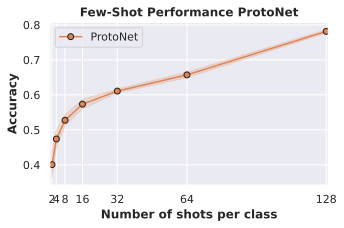

In [52]:
ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
plt.show()
plt.close()